In [11]:
import numpy as np
from torch import nn
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Preprocessing

In [12]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
print(messages.groupby("label").describe())

      message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4


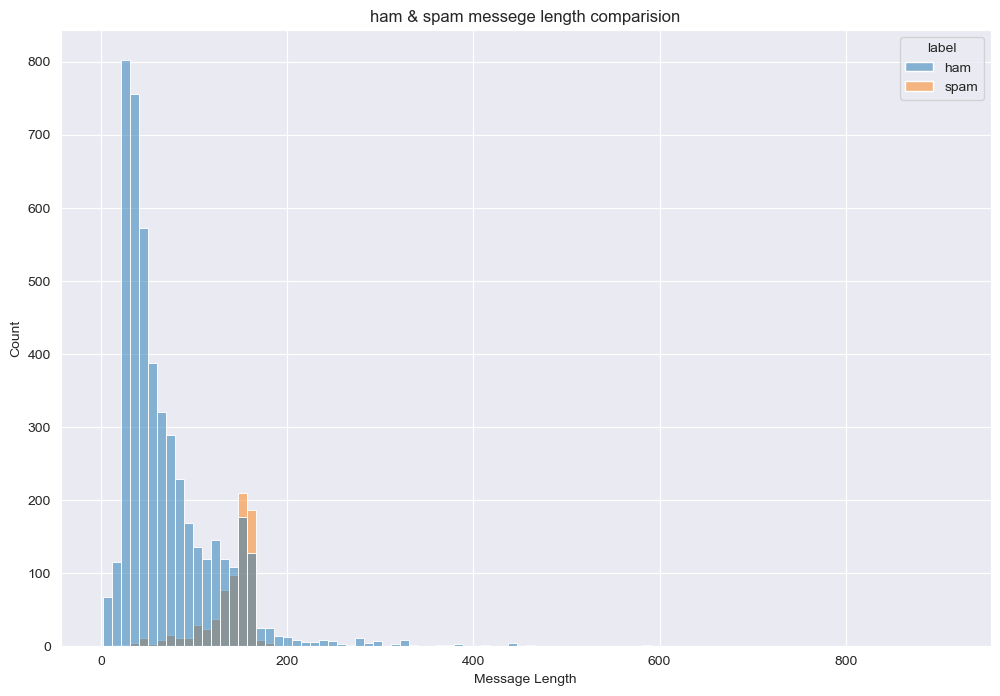

In [14]:
messages["Message Length"]=messages["message"].apply(len)
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=messages["Message Length"],
    hue=messages["label"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [15]:
ham_desc=messages[messages["label"]=="ham"]["Message Length"].describe()
spam_desc=messages[messages["label"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

Ham Messege Length Description:
 count    4825.000000
mean       71.482487
std        58.440652
min         2.000000
25%        33.000000
50%        52.000000
75%        93.000000
max       910.000000
Name: Message Length, dtype: float64
************************************
Spam Message Length Description:
 count    747.000000
mean     138.670683
std       28.873603
min       13.000000
25%      133.000000
50%      149.000000
75%      157.000000
max      223.000000
Name: Message Length, dtype: float64


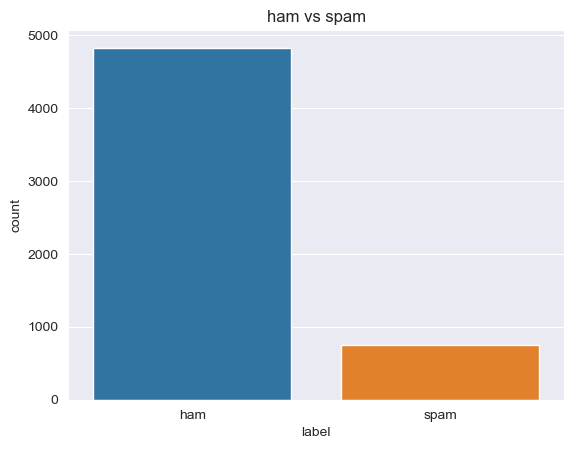

In [16]:
sns.countplot(
    data=messages,
    x="label"
)
plt.title("ham vs spam")
plt.show()

### Data Cleaning (undersampling for imbalanced data)

In [17]:
#compute the length of majority & minority class
minority_len=len(messages[messages["label"]=="spam"])
majority_len=len(messages[messages["label"]=="ham"])

#store the indices of majority and minority class
minority_indices=messages[messages["label"]=="spam"].index
majority_indices=messages[messages["label"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

#create df using new indices
df=messages.loc[undersampled_indices]

#shuffle the sample
df=df.sample(frac=1)

#reset the index as its all mixed
df=df.reset_index()

#drop the older index
df=df.drop(
    columns=["index"],
)
print("df shape: ", df.shape)
df['label'].value_counts()

df shape:  (1494, 3)


spam    747
ham     747
Name: label, dtype: int64

In [18]:
df["Label"]=df["label"].map(
    {
        "ham":0,
        "spam":1
    }
)

### Data Processing and Tokenization

In [ ]:
import torch
from torchtext import data
import warnings as wrn
wrn.filterwarnings("ignore")

text = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
label = data.LabelField(dtype = torch.float,batch_first=True)

fields = [("type",label),('text',text)]

# load data from df
training_data=data.TabularDataset(
    path="",
    format="csv",
    fields=fields,
    skip_header=True,
    csv_reader_params={
        "delimiter":"\t",
        "quotechar":"None"
    },
    data=df.to_csv()
)
print(vars(training_data.examples[0]))